Experiments:

19540 - initial experiment without feeding parameters, only lasted till around 1000 iterations.

In [1]:
# do data cleaning and create appropriate dataloaders
# to exhaustively cover the entire training dataset. 
# build PC regression module to perform sparse regression
# between the parameter-timestep combinations and the initial
# frames for "synthetic" data generation (i.e. don't pass test
# images directly)

# also create some plotting utils to appropriately process and
# save the images, with correct ticklabels.

In [3]:
import torch
import torch.nn 
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import Sampler
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import os
import re
import sys
import logging
import torchvision
import torchvision.transforms as T
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

/home/ajivani/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/ajivani/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
args = {
    # "niters": 1000,
    "niters": 1500,
    # "niters":150,
    "lr": 1e-3,
    "save": "experiments/",
    "save_figs": "prediction_figs/",
    "load": 19540,
    "r": 1991,
    "node-layers": 2,
    "mlp-layers": 1,
    "latents": 8,  # 68818 has 8 latent dims
    "units": 50,
    "resize_dims": (16, 64),
    "param_scaling": [1, 1],
    "warm_start": 20376,
    "do_warm_start": False,
    "quadratic": False,
    # "loss": "smooth_l1",
    "loss": "mae",
    # "loss": "hybrid", # combine mae and ssim
    "batch_size": 4,
    "steps_to_predict": 8,
    "sampled_ics": 4,
    "dropout":False
}

In [5]:
import torch
import torch.nn 
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import os
import re
import sys
import logging
import torchvision
import torchvision.transforms as T
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

import node_utils as nut
import data_utils as dut

import time
import datetime
import argparse
import copy
import numpy as np
# import pandas as pd
from random import SystemRandom

from rich.progress import track
import tqdm

adjoint=True
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

from sunpy.visualization import colormaps as cm

lc3_reg = cm.cmlist['soholasco3']
lc3 = cm.cmlist['soholasco3'].reversed()

import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt

plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
cme_params_scaled = pd.read_csv("./old_data_surrogate/CMEParams2161_Scaled.csv")
# cme_params_scaled.head()

# rename unnamed column to SimID
cme_params_scaled = cme_params_scaled.rename(columns={'Unnamed: 0': 'SimID'})
# cme_params_scaled = cme_params_scaled.loc[:, ~cme_params_scaled.columns.str.contains('^Unnamed')]
cme_params_scaled.head()

,SimID,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506


In [7]:
# Load IDs to keep amongst successful runs (1-indexed!)
ids_to_keep_raw = np.load("./old_data_surrogate/ids_to_keep_2161.npy")
ids_to_keep = ids_to_keep_raw - 1
ids_to_keep.shape

(254,)

In [8]:
successful_sim_ids = cme_params_scaled['SimID'].to_numpy()

In [9]:
indices_to_keep = np.where(np.isin(successful_sim_ids, ids_to_keep))[0]

In [10]:
filtered_df = cme_params_scaled[cme_params_scaled['SimID'].isin(ids_to_keep)]

In [11]:
cme_params_np = filtered_df.iloc[:, 1:].to_numpy()

In [12]:
raw_images = np.load("./old_data_surrogate/CR2161_tDecay2h_Polar_Compressed.npy")

In [13]:
raw_images_to_keep = raw_images[:62, :, :, indices_to_keep]
raw_min, raw_max = raw_images_to_keep.min(), raw_images_to_keep.max()

In [14]:
num_sim = len(indices_to_keep)
data_sim_ids = np.linspace(0, num_sim - 1, num_sim, dtype=int)

generator1 = torch.Generator().manual_seed(2024)
train_frac, val_frac, test_frac = 0.7, 0.1, 0.2
train_valid_test = random_split(data_sim_ids,
                                [train_frac, val_frac, test_frac],
                                # [train_size, valid_size, test_size],
                                generator=generator1)

train_idx = np.array(train_valid_test[0].indices)
val_idx = np.array(train_valid_test[1].indices)
test_idx = np.array(train_valid_test[2].indices)

ntrain = train_idx.shape[0]
nval = val_idx.shape[0]
ntest = test_idx.shape[0]
ntrain, nval, ntest

(178, 26, 50)

In [15]:
train_data_raw = raw_images_to_keep[:, :, :, train_idx]
val_data_raw = raw_images_to_keep[:, :, :, val_idx]
test_data_raw = raw_images_to_keep[:, :, :, test_idx]

In [16]:
resize_dims = args["resize_dims"]

train_data_resized = T.Resize(size=resize_dims,
                                  antialias=True
                                  )(torch.Tensor(train_data_raw.transpose(3, 2, 0, 1)))

val_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(val_data_raw.transpose(3, 2, 0, 1)))

test_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(test_data_raw.transpose(3, 2, 0, 1)))

In [17]:
max_train = torch.max(train_data_resized)
min_train = torch.min(train_data_resized)

max_train, min_train

(tensor(1.5000), tensor(0.9356))

In [18]:
# all_timesteps = np.linspace(2, 182, 90, dtype=int) # adding extra timestep to accomodate the last observation.

tt_og = np.linspace(2, 180, 90, dtype=int)
tt_og_ts = np.linspace(0, 1, 90)

tMinIdxSim = 50
tMaxIdxSim = len(tt_og) - 1

print(tMinIdxSim, tMaxIdxSim)

tstartSim = tt_og_ts[tMinIdxSim]
tendSim = tt_og_ts[tMaxIdxSim]
nTimesteps_sim = tMaxIdxSim - tMinIdxSim + 1
tt_predictSim = np.linspace(tstartSim, tendSim, nTimesteps_sim)
tt_predictSim = torch.Tensor(tt_predictSim).to(device)

nTimesteps_sim, tt_predictSim

50 89


(40,
 tensor([0.5618, 0.5730, 0.5843, 0.5955, 0.6067, 0.6180, 0.6292, 0.6404, 0.6517,
         0.6629, 0.6742, 0.6854, 0.6966, 0.7079, 0.7191, 0.7303, 0.7416, 0.7528,
         0.7640, 0.7753, 0.7865, 0.7978, 0.8090, 0.8202, 0.8315, 0.8427, 0.8539,
         0.8652, 0.8764, 0.8876, 0.8989, 0.9101, 0.9213, 0.9326, 0.9438, 0.9551,
         0.9663, 0.9775, 0.9888, 1.0000]))

In [19]:
tt_predictSim.shape

torch.Size([40])

In [20]:
train_data = (train_data_resized[:, tMinIdxSim:(tMaxIdxSim + 1), :, :] - min_train)/(max_train - min_train)
val_data = (val_data_resized[:, tMinIdxSim:(tMaxIdxSim + 1), :, :] - min_train)/(max_train - min_train)
test_data = (test_data_resized[:, tMinIdxSim:(tMaxIdxSim + 1), :, :] - min_train)/(max_train - min_train)

In [21]:
train_params_raw = cme_params_np[train_idx, :]
valid_params_raw = cme_params_np[val_idx, :]
test_params_raw = cme_params_np[test_idx, :]

In [22]:
expanded_tpredict_train = tt_predictSim.view(1, nTimesteps_sim, 1).expand(ntrain, nTimesteps_sim, -1)
expanded_tpredict_val = tt_predictSim.view(1, nTimesteps_sim, 1).expand(nval, nTimesteps_sim, -1)
expanded_tpredict_test = tt_predictSim.view(1, nTimesteps_sim, 1).expand(ntest, nTimesteps_sim, -1)

expanded_tpredict_train.shape

torch.Size([178, 40, 1])

In [23]:
train_snaps = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
val_snaps = val_data.reshape((val_data.shape[0], val_data.shape[1], -1))
test_snaps = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

# reshape tpredict to be the same dimensions as train snaps etc.

train_snaps_concat = torch.cat((train_snaps, expanded_tpredict_train), 2)
val_snaps_concat = torch.cat((val_snaps, expanded_tpredict_val), 2)
test_snaps_concat = torch.cat((test_snaps, expanded_tpredict_test), 2)

# repeat parameter values up to number of timesteps
train_params_ts = np.repeat(train_params_raw.reshape((train_params_raw.shape[0], train_params_raw.shape[1], 1)), nTimesteps_sim, axis=2)
val_params_ts = np.repeat(valid_params_raw.reshape((valid_params_raw.shape[0], valid_params_raw.shape[1], 1)), nTimesteps_sim, axis=2)
test_params_ts = np.repeat(test_params_raw.reshape((test_params_raw.shape[0], test_params_raw.shape[1], 1)), nTimesteps_sim, axis=2)

# concatenate snaps and params
train_all = torch.cat((train_snaps_concat, torch.Tensor(np.transpose(train_params_ts, (0, 2, 1)))), 2)
val_all = torch.cat((val_snaps_concat, torch.Tensor(np.transpose(val_params_ts, (0, 2, 1)))), 2)
test_all = torch.cat((test_snaps_concat, torch.Tensor(np.transpose(test_params_ts, (0, 2, 1)))), 2)

In [24]:
train_all.shape, val_all.shape, test_all.shape

(torch.Size([178, 40, 1034]),
 torch.Size([26, 40, 1034]),
 torch.Size([50, 40, 1034]))

In [25]:
# train_dataset = []
# val_dataset = []

# we will predict the full time series for test dataset starting from the 
# initial condition only, without any intermediate sampling.

test_dataset = []
# for i in range(ntrain):
#     for j in range(1, nTimesteps_sim - 1):
#         train_dataset.append((train_all[i:(i+1), (j-1), :], train_all[i:(i+1), (j-1):(j+2), :], tt_predictSim[(j-1):(j+2)]))

# for i in range(nval):
#     for j in range(1, nTimesteps_sim - 1):
#         val_dataset.append((val_all[i:(i+1), (j-1), :],
#                             val_all[i:(i+1), (j-1):(j+2), :],
#                             tt_predictSim[(j-1):(j+2)]))

for i in range(ntest):
        test_dataset.append((test_all[i:(i+1), 0, :],
                             test_all[i:(i+1), :, :],
                             tt_predictSim))
        
# test_dataset_ar = []
# for i in range(ntest):
#     for j in range(1, nTimesteps_sim - 1):
#         test_dataset_ar.append((test_all[i:(i+1), (j-1), :],
#                             test_all[i:(i+1), (j-1):(j+2), :],
#                             tt_predictSim[(j-1):(j+2)]))

In [26]:
# tt_predictSim[(j-1):(j+2)]

In [27]:
# len(train_dataset)

In [28]:
6764/178

38.0

In [29]:
class SimulationDataset(Dataset):
    def __init__(self, all_data, tt_predictSim, nsims, nTimesteps_sim):
        """
        all_data - one of train_all, val_all, test_all
        nsims - one of ntrain, nval, nsim
        """
        self.data_all = all_data
        self.tt_predictSim = tt_predictSim
        self.ndata = nsims
        self.nTimesteps_sim = nTimesteps_sim
        # self.data_pairs = []

        # for j in range(1, nTimesteps_sim - 1):
        #     for i in range(nsims):
        #         # Append (i, j-1) to form data pairs for later lookup
        #         self.data_pairs.append((i, j-1))
    
    # def __len__(self):
    #     return len(self.data_pairs)
    
    def __len__(self):
        return self.ndata * (self.nTimesteps_sim - 2)
    
    def __getitem__(self, idx):
        # i, j_minus_1 = self.data_pairs[idx]
        # Retrieve data for (i, j-1)
        i, j_minus_1 = idx
        input_ = self.data_all[i:(i+1), j_minus_1, :]
        sequence_ = self.data_all[i:(i+1), j_minus_1:(j_minus_1+3), :]
        tt_sequence = self.tt_predictSim[j_minus_1:(j_minus_1+3)]
        
        return i, j_minus_1, input_, sequence_, tt_sequence

In [30]:
class ConsistentTimeWindowSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.batch_size = batch_size
        self.nTimesteps_sim = dataset.nTimesteps_sim
        self.ndata = dataset.ndata
        self.time_windows = list(range(0, self.nTimesteps_sim - 2))
        np.random.shuffle(self.time_windows)
        
    def __iter__(self):
        for time_idx in self.time_windows:
            sim_indices = np.random.choice(self.ndata, self.batch_size, replace=False)
            batch = [(sim_idx, time_idx) for sim_idx in sim_indices]
            yield batch
            
    def __len__(self):
        return len(self.time_windows) * (self.ndata // self.batch_size)

In [31]:
train_dataset = SimulationDataset(train_all, tt_predictSim, ntrain, nTimesteps_sim)
train_sampler = ConsistentTimeWindowSampler(train_dataset, batch_size = 8)
train_dataloader = DataLoader(train_dataset, batch_sampler=train_sampler)

val_dataset = SimulationDataset(val_all, tt_predictSim, nval, nTimesteps_sim)
val_sampler = ConsistentTimeWindowSampler(val_dataset, batch_size=8)
val_dataloader = DataLoader(val_dataset, batch_sampler=val_sampler)

# test_dataset = SimulationDataset(test_all, tt_predictSim, ntest, nTimesteps_sim)
# test_sampler = ConsistentTimeWindowSampler(test_dataset, batch_size = ntest)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [32]:
# bbb = test_dataloader.__iter__().__next__()
# len(bbb)

In [33]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(836, 114, 1)

In [34]:
nval, ntest
26 * 38, 50 * 38

(988, 1900)

In [35]:
nTimesteps_sim

40

In [36]:
# train_dataloader = DataLoader(train_dataset, 
#                               batch_size = 8, 
#                               shuffle=True)
    

# val_dataloader = DataLoader(val_dataset,
#                         batch_size = len(val_dataset),
#                         shuffle=False)

# test_dataloader = DataLoader(test_dataset,
#                         batch_size = len(test_dataset),
#                         shuffle=False)

In [37]:
# blah = train_dataloader.__iter__().__next__()
# blah[0].shape, blah[1].shape

In [38]:
# blah[-1]

In [39]:
class ODENet(nn.Module):
    def __init__(self, 
                 latent_dim, 
                 param_dim,
                 device,
                 n_layers=2,
                 n_units=50,
                 n_units_q=100,
                 nonlinear=nn.ELU,
                 quadratic=False):
    
        super(ODENet, self).__init__()
        # layers = [nn.Linear(latent_dim + param_dim, n_units)]
        layers = [nn.Linear(latent_dim, n_units)]
        for i in range(n_layers - 1):
            layers.append(nonlinear())
            layers.append(nn.Linear(n_units, n_units))

        layers.append(nonlinear())
        layers.append(nn.Linear(n_units, latent_dim))  

        odenet = nn.Sequential(*layers)

        nut.init_network_weights_xavier_normal(odenet)

        self.odenet = odenet
        # self.odenet_q = odenet_q
        self.latent_dim = latent_dim
        self.quadratic = quadratic
        self.device = device

    def quadratic_y(self, y):
        pass

    def forward(self, t, y):
        output = self.odenet(y)
        return output

In [40]:
class PNODE_Conv(nn.Module):
    def __init__(self, 
                 input_dim,
                 latent_dim,
                 param_dim,
                 device,
                 n_layers=2, 
                 n_units=50,
                 nonlinear=nn.ELU,
                 quadratic=False,
                 dropout=False,
                 resize_dims=(32, 128)):
        super(PNODE_Conv, self).__init__()
        
        if dropout==True:
            self.regularize = nn.Dropout(0.6)
        else:
            self.regularize = nn.Identity()
        
        self.resize_dims=resize_dims
        encoder = nn.Sequential(nn.ZeroPad2d((7,8,7,8)),
                        nn.Conv2d(1,4,16,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.ZeroPad2d((3,4,3,4)),
                        nn.Conv2d(4,8,8,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.ZeroPad2d((1,2,1,2)),
                        nn.Conv2d(8,16,4,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.ZeroPad2d((0,1,0,1)),
                        nn.Conv2d(16,32,2,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.ZeroPad2d((0,0,0,0)),
                        nn.Conv2d(32,64,1,stride=(2,2),padding=(0,0)),
                        nn.ELU(),
                        nn.Flatten(),
                        # nn.Linear(256,latent_dim),
                        nn.Linear(128, latent_dim),
                        nn.ELU(),
                        self.regularize) 
                
        decoder_mlp = nn.Sequential(nn.Linear(latent_dim, 128),
                                    # nn.Linear(latent_dim, 256),
                                    nn.ELU(),
                                   self.regularize)
        
        decoder_conv = nn.Sequential(nn.ConvTranspose2d(64,32,(4,4),stride=(2,2),padding=(1,1)),
            nn.ELU(),
            nn.ConvTranspose2d(32,16,(4,4),stride=(2,2),padding=(1,1)),
            nn.ELU(),
            nn.ConvTranspose2d(16,8,(8,8),stride=(2,2),padding=(3,3)),
            nn.ELU(),
            # nn.ConvTranspose2d(8,4,(16,16),stride=(2,2),padding=(7,7)),
            # nn.ELU(),
            # nn.ConvTranspose2d(4,1,(16,16),stride=(2,2),padding=(7,7)),
            # nn.ELU()
            )        
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        self.encoder=encoder
        self.pnode=ODENet(latent_dim, 
                          param_dim,
                          device,
                          n_layers=n_layers,
                          n_units=n_units,
                          quadratic=quadratic).to(device)
        
        if quadratic == True:
            print("Using lin-quad PNODE")
        else:
            print("Using regular PNODE")

        self.decoder_mlp = decoder_mlp
        self.decoder_conv = decoder_conv
        
        
        nut.init_network_weights_xavier_normal(self.encoder)
        nut.init_network_weights_xavier_normal(self.decoder_mlp)
        nut.init_network_weights_xavier_normal(self.decoder_conv)
        
        
    def forward(self, t, y):
        init_state = y[:, :, :self.input_dim]
        nbatch, ntraj, nseq = init_state.shape
        init_state = init_state.reshape((nbatch * ntraj, 1, self.resize_dims[0], self.resize_dims[1]))
        init_latent = self.encoder(init_state).reshape((nbatch, ntraj, self.latent_dim))
        # init_latent = torch.cat((init_latent, y[:, :, self.input_dim:]),-1)
        latent_states = odeint(self.pnode, init_latent, t)
        ls_init = latent_states[:, :, :, :self.latent_dim]
        ntraj2, nbatch2, nseq2, _  = ls_init.shape
        latent_mlp = self.decoder_mlp(ls_init)
        decoder_features = latent_mlp.reshape((-1, 64, 1, 4))
        pred_sol = self.decoder_conv(decoder_features)
        pred_sol = pred_sol.reshape((ntraj2, nbatch2, nseq2, int(self.resize_dims[0] * self.resize_dims[1])))
        
        return pred_sol

In [41]:
input_dim = int(resize_dims[0] * resize_dims[1])
input_dim

1024

In [42]:
model = PNODE_Conv(input_dim=input_dim, 
                       latent_dim=args["latents"], 
                       param_dim=4, 
                       device=device,
                       n_layers=args["node-layers"],
                       n_units=args["units"],
                       quadratic=args["quadratic"],
                       dropout=args["dropout"],
                       resize_dims=args["resize_dims"]).to(device)

Using regular PNODE


In [43]:
args["latents"]

8

In [44]:
pEncoder = nut.count_parameters(model.encoder)
pPNODE = nut.count_parameters(model.pnode)
pDecoder = nut.count_parameters(model.decoder_mlp) + nut.count_parameters(model.decoder_conv)

print("Total Number of Parameters: ")
print(pEncoder + pPNODE + pDecoder)

Total Number of Parameters: 
64140


In [45]:
nut.makedirs(os.path.join(os.getcwd(), "logs"))
logdir = os.path.join(os.getcwd(), "logs")

exptdir = os.path.join(os.getcwd(), args["save"])
nut.makedirs(exptdir)
# nut.makedirs("./model_stopping")

if args["load"] is not None:
    experimentID = args["load"]
    print("Loading experiment")
else:
    if args["do_warm_start"] == True:
        experimentID = args["warm_start"]
        print("Warm starting previous experiment")
    else:
        experimentID = int(SystemRandom().random()*100000)
        print("Starting new experiment")

print("Experiment ID: ")
print(experimentID)

ckpt_path = os.path.join(exptdir, "experiment_" + str(experimentID) + '.ckpt')

print("Checkpoint Path: ")
print(ckpt_path)

logger = dut.get_logger(logpath=os.path.join(logdir, "expt_normalized_pnode_images_2.log"))
logger

logger.info(os.getcwd())
logger.info(model)
logger.info("Number of parameters: {}".format(pEncoder + pPNODE + pDecoder))
logger.info(args)
logger.info("Checkpoint Path")
logger.info(ckpt_path)
logger.info("Input Dim: ")
logger.info(input_dim)
logger.info("Param Dim: ")
logger.info(4)
logger.info("Latent Dim: ")
logger.info(args["latents"])
logger.info(device)

/home/ajivani/WLROM_new/WhiteLight
PNODE_Conv(
  (regularize): Identity()
  (encoder): Sequential(
    (0): ZeroPad2d((7, 8, 7, 8))
    (1): Conv2d(1, 4, kernel_size=(16, 16), stride=(2, 2))
    (2): ELU(alpha=1.0)
    (3): ZeroPad2d((3, 4, 3, 4))
    (4): Conv2d(4, 8, kernel_size=(8, 8), stride=(2, 2))
    (5): ELU(alpha=1.0)
    (6): ZeroPad2d((1, 2, 1, 2))
    (7): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
    (8): ELU(alpha=1.0)
    (9): ZeroPad2d((0, 1, 0, 1))
    (10): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    (11): ELU(alpha=1.0)
    (12): ZeroPad2d((0, 0, 0, 0))
    (13): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
    (14): ELU(alpha=1.0)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=128, out_features=8, bias=True)
    (17): ELU(alpha=1.0)
    (18): Identity()
  )
  (pnode): ODENet(
    (odenet): Sequential(
      (0): Linear(in_features=8, out_features=50, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=50,

Loading experiment
Experiment ID: 
19540
Checkpoint Path: 
/home/ajivani/WLROM_new/WhiteLight/experiments/experiment_19540.ckpt


In [46]:
# blah = train_dataloader.__iter__().__next__()
# blah[0].shape, blah[1].shape, blah[2].shape, blah[3].shape, blah[-1].shape

In [47]:
# blah[-1]

In [48]:
# ll = [model(blah[2][0], blah[0])[:, 0, :, :], model(blah[2][1], blah[0])[:, 1, :, :]]

In [49]:
# blah[1].shape

In [50]:
optimizer = optim.Adamax(model.parameters(), lr=args["lr"])
val_loss_list = []
train_loss_list = []

num_batches = 1
early_stopping = nut.EarlyStopping(patience=20,
                                verbose=True,
                                path=ckpt_path)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.6, patience=40)
ckpt_freq=10
trainMax = copy.deepcopy(min_train)
trainMin = copy.deepcopy(max_train)


if args["load"] is None:
    # This is us trying to warm start predictions.
    if args["do_warm_start"] == True:
        checkpoint = torch.load(ckpt_path)
        model.load_state_dict(checkpoint['model'])
        start_epoch = checkpoint['epoch']
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        print("Warm Starting Experiment {} from Epoch {}".format(experimentID, start_epoch))
    else:
        start_epoch = 0
        print("Starting a new experiment {} from Epoch {}".format(experimentID, start_epoch))
    
    # Resume training from a specific epoch
    for itr in track(range(start_epoch + 1, num_batches * (args["niters"] + 1)), description="Looping over Epochs..."):
        model.train()
    # for itr in track(range(1, num_batches * (args["niters"] + 1)), description="Looping over Epochs..."):
        optimizer.zero_grad()
                
        # all_batch_dicts = dut.get_next_batch(dut.inf_generator(train_dataloader)
        for i, batch_dict in enumerate(train_dataloader):
            # print(batch_dict["observed_data"].shape)
            sim_idx, tidx, obs_data, data_to_predict, tp_predict = batch_dict[0], batch_dict[1], batch_dict[2], batch_dict[3], batch_dict[4]
            
            # raw_preds = torch.zeros(3, obs_data.shape[0], 1, input_dim).to(device)
            raw_preds = model(tp_predict[0, :], obs_data)
            
            # for jj in range(obs_data.shape[0]):
                # raw_pred = model(tp_predict[jj, :], obs_data)
                # raw_preds[:, jj, :, :] = raw_pred[:, jj, :, :]

            model_pred = torch.permute(torch.squeeze(raw_preds), (1, 0, 2)) * (trainMax - trainMin) + trainMin
            target = torch.squeeze(data_to_predict[:, :, :, :input_dim]) * (trainMax - trainMin) + trainMin

            # print(target.shape, model_pred.shape)

            train_loss = nut.oden_loss(target, model_pred, loss=args["loss"])

            train_loss.backward()
            optimizer.step()
            train_loss_list.append(train_loss.item())
            

        model.eval()
        
        for i, val_dict in enumerate(val_dataloader):
        # for val_dict in all_val_dicts:
            val_idx, val_t_idx, val_data, val_to_predict, tp_predict_val = val_dict[0], val_dict[1], val_dict[2], val_dict[3], val_dict[4]
            # raw_val_preds = torch.zeros(3, val_data.shape[0], 1, input_dim).to(device)
            # for jj in range(val_data.shape[0]):
                # raw_val_pred = model(tp_predict_val[jj, :], val_data)
                # raw_val_preds[:, jj, :, :] = raw_val_pred[:, jj, :, :]
                
            raw_val_preds = model(tp_predict_val[0, :], val_data)

            val_pred = torch.permute(torch.squeeze(raw_val_preds), (1, 0, 2)) * (trainMax - trainMin) + trainMin
            val_target = torch.squeeze(val_to_predict[:, :, :, :input_dim]) * (trainMax - trainMin) + trainMin

            val_loss = nut.oden_loss(val_target, val_pred, loss=args["loss"])
            
            
            val_loss_list.append(val_loss.item())

        message = 'Epoch {:04d}|Val loss {:.6e}|Train loss {:.6e}|LR {:.5f}|'.format(
                        itr//num_batches,
                        val_loss.item(), 
                        train_loss.item(), 
                        optimizer.param_groups[0]["lr"])

        logger.info(message)
        scheduler.step(val_loss)
        if itr % ckpt_freq == 0:
            early_stopping(val_loss, model, optimizer, itr, args)


        if early_stopping.early_stop:
            print('Early stopping')
            torch.save(model.state_dict(), os.path.join(args["save"], "experiment_" + str(experimentID) + '_early_stopping.ckpt'))
            break
        
else:
    # check if early stopping checkpoint exists, load that if the case.
    early_stop_filepath = os.path.join(args["save"], "experiment_" + str(experimentID) + "_early_stopping.ckpt")
    if os.path.exists(early_stop_filepath):
        early_stp_ckpt = torch.load(early_stop_filepath)
        model.load_state_dict(early_stp_ckpt)
    else:
        nut.get_ckpt_model(ckpt_path, model, device)

In [72]:
model.eval()

test_data = dut.get_next_batch(dut.inf_generator(test_dataloader))
test_target = torch.squeeze(test_data[1])[:, :, :1024] * (trainMax - trainMin) + trainMin
with torch.no_grad():
    test_pred_raw = model(tt_predictSim,
                      test_data[0])
    test_pred_og = torch.permute(torch.squeeze(test_pred_raw),
                                 (1, 0, 2))* (trainMax - trainMin) + trainMin
test_target.shape, test_pred_og.shape

(torch.Size([50, 40, 1024]), torch.Size([50, 40, 1024]))

In [74]:
test_pred_rs = test_pred_og.reshape((-1, len(tt_predictSim), 16, 64)).cpu()
test_target_rs = test_target.reshape((-1, len(tt_predictSim), 16, 64)).cpu()

test_pred_rs.shape, test_target_rs.shape

(torch.Size([50, 40, 16, 64]), torch.Size([50, 40, 16, 64]))

In [ ]:
# ax.set(xticks=np.arange(0, 400, step = 99.9), xticklabels = ['-182', '-112','-41', '29', '99'],
                   # yticks=np.arange(0, 128, step = 63.999), yticklabels=['4','14','24'])
# fig.text(0.5, 0.03, r'$\theta$ [deg]', ha='center', fontsize = 40)

# fig.text(0.04, 0.5, "Solar Radii [R]", va='center', rotation='vertical', fontsize = 40)

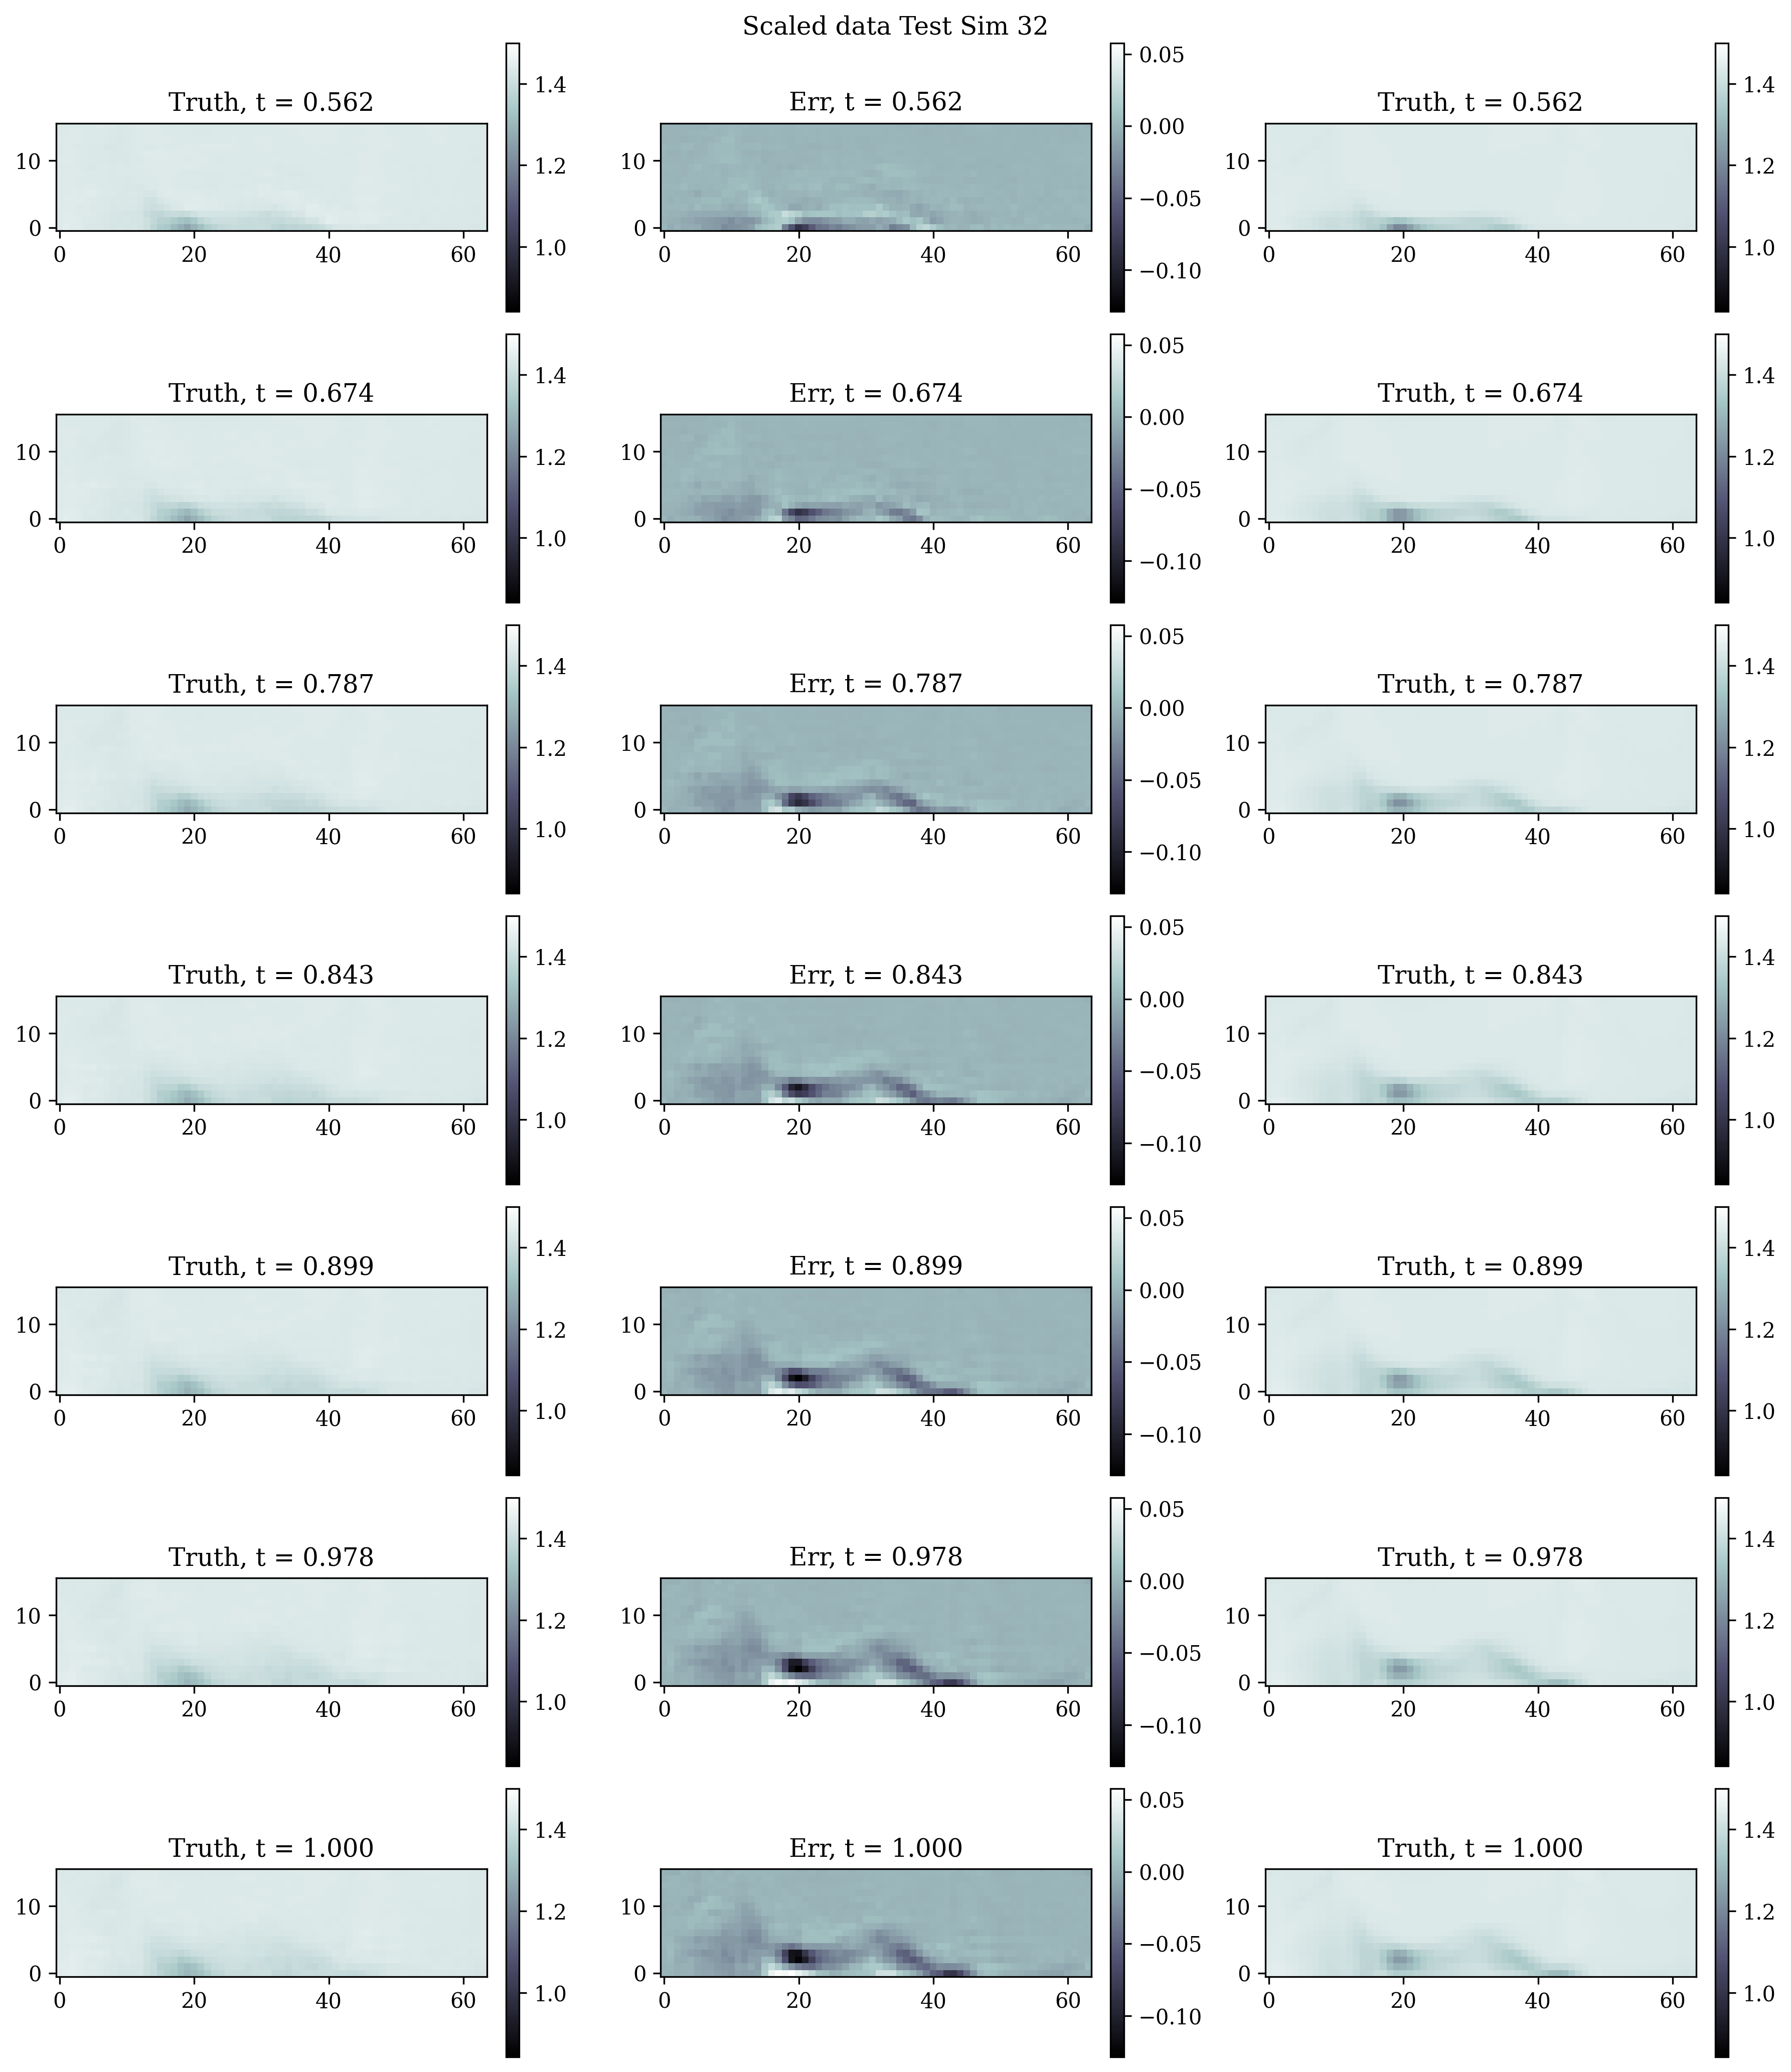

In [80]:
time_idx_to_plot = np.array([0, 10, 20, 25, 30, 37, 39])
sim_idx = 32

test_err_sim = test_target_rs[sim_idx, :, :, :] - test_pred_rs[sim_idx, :, :]
# print(test_err_sim.shape)

fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(12, 14))

for row in range(7):
    im = axs[row, 0].imshow(test_pred_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3_reg,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 0])
    axs[row, 0].set_title("Truth, t = {:.3f}".format(tt_predictSim[time_idx_to_plot[row]]))
    
    
for row in range(7):
    im = axs[row, 1].imshow(test_err_sim[time_idx_to_plot[row], :, :],
                            origin="lower",
                            cmap=lc3_reg,
                            vmin=test_err_sim.min(),
                            vmax=test_err_sim.max()
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 1])
    axs[row, 1].set_title("Err, t = {:.3f}".format(tt_predictSim[time_idx_to_plot[row]]))
    
for row in range(7):
    im = axs[row, 2].imshow(test_target_rs[sim_idx, time_idx_to_plot[row], :, :],
                           origin="lower",
                           cmap=lc3_reg,
                           vmin=trainMin,
                           vmax=trainMax
                           )
    plt.colorbar(im, fraction=0.046, pad=0.04, ax=axs[row, 2])
    axs[row, 2].set_title("Truth, t = {:.3f}".format(tt_predictSim[time_idx_to_plot[row]]))

fig.suptitle("Scaled data Test Sim {}".format(sim_idx))
fig.tight_layout()

In [ ]:
def plotICAndTarget(dataloader_object, 
                    type_dl="val", 
                    param_dim=4,
                    savedir="./scratch_figs/dataloader_figs"):
    time_idx_to_plot = [0, 10, 20, 30, -1]
    bd = dut.get_next_batch(dut.inf_generator(dataloader_object))
    
    ip_dims = bd["observed_data"].shape[2] - param_dim
    
    nsims = bd["observed_data"].shape[1]
    ntimes = bd["data_to_predict"].shape[1]
    
    ic_np = bd["observed_data"].squeeze(0).cpu().detach().numpy()
    dp_np = bd["data_to_predict"].cpu().detach().numpy()
    
    # print(dp_np[:, 0, :].shape)
    assert np.all(ic_np[:, :ip_dims] == dp_np[:, 0, :])
    
    
    
    for i in range(nsims):
        print("Processing for sim ", i)
        fig, ax = plt.subplots(nrows=len(time_idx_to_plot), ncols=1, figsize=(4, 10))
        for row in range(len(time_idx_to_plot)):
            im = ax[row].imshow(dp_np[i, time_idx_to_plot[row], :].reshape((16, 64)),
                                origin="lower",
                                cmap="viridis"
                               )
            fig.colorbar(im, fraction=0.046, pad=0.04, ax=ax[row])                         
                                      
        fig.suptitle("Raw data sim ID {:03d}".format(i))
        plt.tight_layout()
        
        nut.makedirs(savedir)
        plt.savefig(os.path.join(savedir, 
                                 "wl_sim_{:03d}_{}.png".format(i,
                                                               type_dl
                                                              )
                                ))
        plt.close()